### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import kstest

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Dataset: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [2]:
df = pd.read_csv("data/cardio_train.csv", sep=";")
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


Choose columns height, weight. ap_hi, ap_lo. 

In [3]:
data = df[["height", "weight", "ap_hi", "ap_lo"]].copy()

Remove outliers: (they are clearly present)

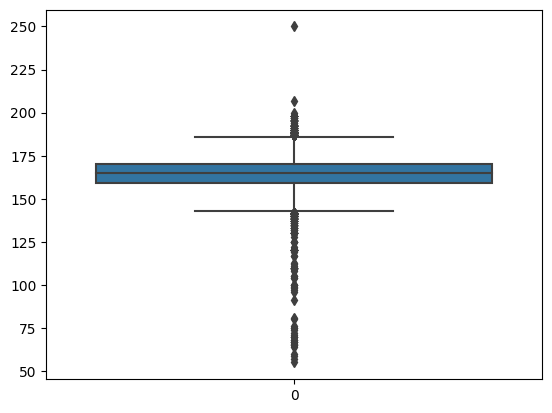

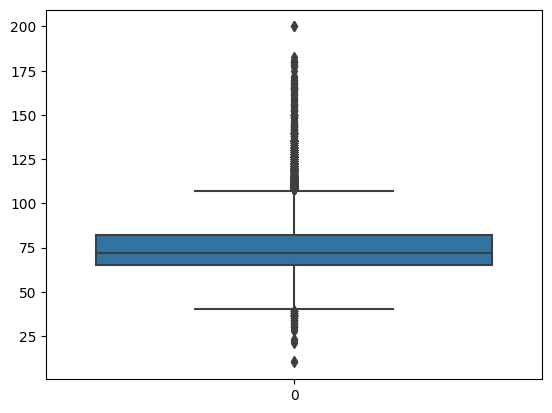

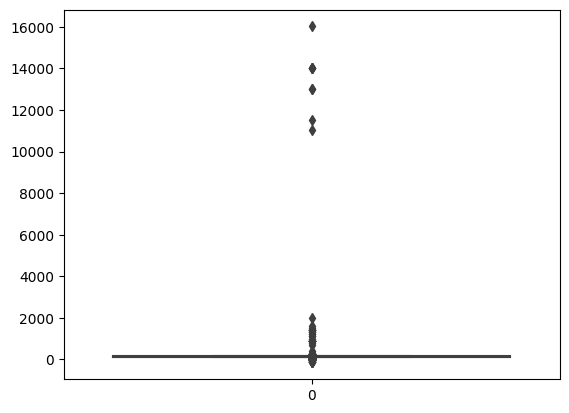

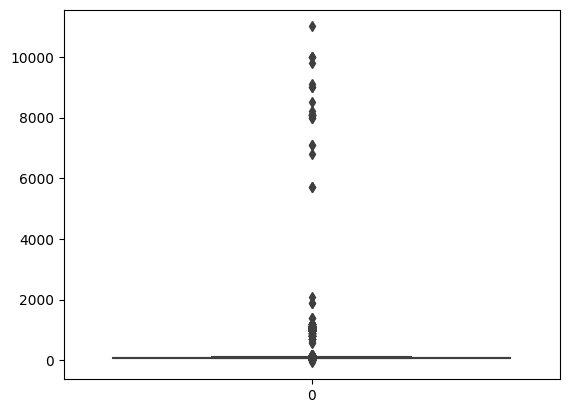

In [4]:
for column in data.columns:
    sns.boxplot(data[column])
    plt.show()

In [5]:
indicies = np.ones(data.shape[0])

for column in data.columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = (data[column]<=upper)
    lower_array = (data[column]>=lower)
    
    indicies = indicies & upper_array & lower_array

In [6]:
data.drop(index=np.arange(0, data.shape[0], 1)[np.logical_not(indicies)], inplace=True)
df.drop(index=np.arange(0, df.shape[0], 1)[np.logical_not(indicies)], inplace=True) 

### 1)

Choose columns height, weight. ap_hi, ap_lo. Test the hypotesis about the normality of the destribution.

QQ-plots:

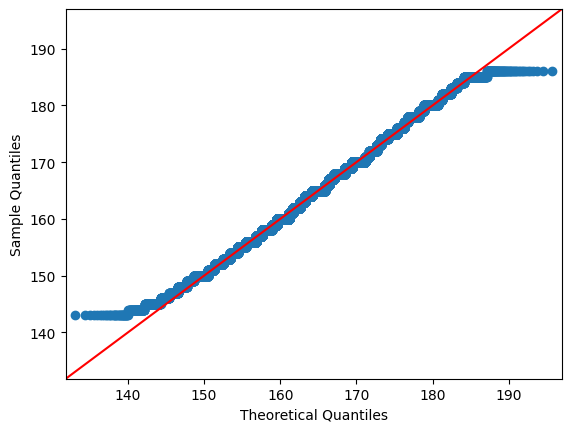

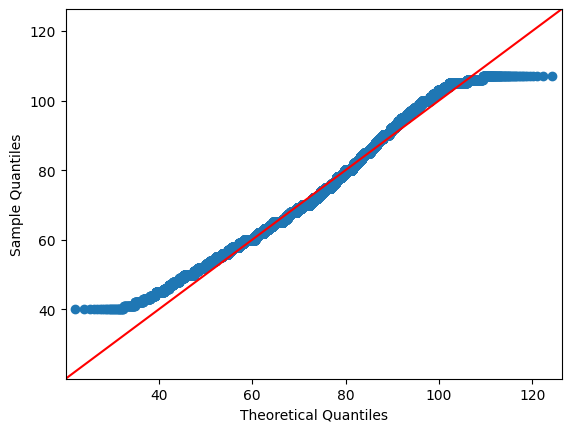

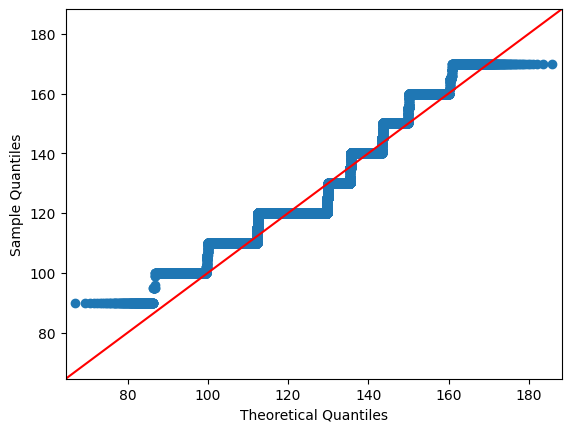

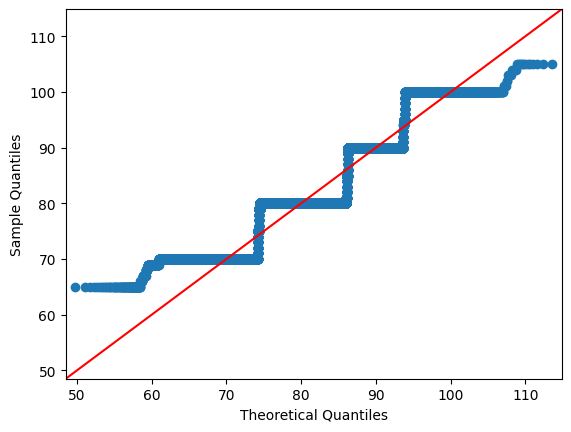

In [7]:
for column in data.columns:
    ksi = data[column].to_numpy()
    fig = sm.qqplot(ksi, line='45', loc=ksi.mean(), scale=ksi.std())
    plt.show()

It is clear that last two are not normal, and the first two might be. We will test this:

Kolmogorov–Smirnov test:

In [8]:
for column in data.columns:
    ksi = data[column].to_numpy()
    print(kstest(ksi, 'norm', args=(ksi.mean(), ksi.std())))

KstestResult(statistic=0.05303431098490641, pvalue=3.0849647663063716e-153, statistic_location=160, statistic_sign=1)
KstestResult(statistic=0.07677759965104541, pvalue=6.433e-321, statistic_location=70.0, statistic_sign=1)
KstestResult(statistic=0.26538037329444186, pvalue=0.0, statistic_location=120, statistic_sign=1)
KstestResult(statistic=0.30339401509010133, pvalue=0.0, statistic_location=80, statistic_sign=1)


$pvalue = 0$, but that is expected for the normality tests, that are designed to test for the ideal normal destribution. With our large real data (and outlier clearing), we should not expect positive results. Let's try to test for normality for smaller subset of data:

In [9]:
np.random.seed(111)

In [10]:
for column in data.columns:
    ksi = data[column].to_numpy()
    ksi_r = np.random.choice(ksi, size=200)
    print(kstest(ksi_r, 'norm', args=(ksi_r.mean(), ksi_r.std())))

KstestResult(statistic=0.07430769603753606, pvalue=0.20878125679711657, statistic_location=170, statistic_sign=1)
KstestResult(statistic=0.060014581818529866, pvalue=0.4498502435539702, statistic_location=70.0, statistic_sign=1)
KstestResult(statistic=0.2489936085545889, pvalue=2.071775423042367e-11, statistic_location=120, statistic_sign=1)
KstestResult(statistic=0.30306365319629114, pvalue=8.535497643689499e-17, statistic_location=80, statistic_sign=1)


Now one can make an argument that first two parameters (weight and height) can be normal. We will conclude this and move on.

### 2)

Create a classification for patient sex (male/female) with naive bias classificator, using normaly distributed parameters from 1). 

Взяти змінні ap_hi, ap_lo, побудувати ядерні оцінки щільності розподілу і зробити класифікацію на 2 групи байєсівським методом.

In [11]:
x = df[['height', 'weight']]
y_true = df['gender']

In [12]:
classificator = GaussianNB()
classificator.fit(x, y_true)
y_pred = classificator.predict(x)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.86      0.83     40718
           2       0.70      0.58      0.63     21787

    accuracy                           0.77     62505
   macro avg       0.75      0.72      0.73     62505
weighted avg       0.76      0.77      0.76     62505



It takes insane amount of computational time, so we will use the kernel estimation on smaller data set:

In [13]:
df_r = df.sample(300)

In [14]:
df_r_typed = [df_r[df_r["gender"] == i+1][["ap_hi", "ap_lo"]] for i in range(2)]

In [15]:
for df_r_i in df_r_typed:
    print(df_r_i.shape[0])

194
106


In [16]:
n_1 = df_r_typed[0].shape[0]
n_2 = df_r_typed[1].shape[0]

In [17]:
S = []
for df_r_i in df_r_typed:
    S.append(df_r_i.cov().to_numpy())
S = np.array(S)

In [18]:
S_pl = 1/( df_r.shape[0] - 2 ) * ((n_1-1)*S[0] + (n_2-1)*S[1])

In [19]:
def f_hat(y, h=1, p=2):
    # normal kernel
    
    coef = 1/(df_r.shape[0] * h**p * (np.linalg.det(S_pl))**0.5)
    
    ans = np.zeros(2)
    for i in range(2):
        for yj in df_r_typed[i].to_numpy():
            ans[i] += np.exp(-(y - yj).T @ np.linalg.inv(S_pl) @ (y - yj) / (2 * h ** 2))

    return coef * ans

def kde_classify(y):
    return np.argmax(f_hat(y)) + 1

In [20]:
%%time
classified = df_r[["ap_hi", "ap_lo"]].apply(kde_classify, axis=1)

CPU times: total: 12.9 s
Wall time: 16.3 s


In [21]:
answer = confusion_matrix(df_r["gender"], classified)
print(answer)

[[193   1]
 [103   3]]


### 3)

Create a linear regression model, using sex variable as a regression target ($y$), and height, weight. ap_hi, ap_lo as variables ($x$)

In [22]:
x = data
y_true = df['gender']

In [23]:
model = LinearRegression()
model.fit(x, y_true)
y_pred = model.predict(x)

In [24]:
print(f"Mean squared error = {mean_squared_error(y_true, y_pred)}")
print(f"R_squared = {r2_score(y_true, y_pred)}")

Mean squared error = 0.16570508557951352
R_squared = 0.27023759703922623


These results are bad, and this is clearly expected, because simple linear regression is not designed to handle the classification problems.

### 4) 

Perform claster analysis using kmeans (use different number of components for showcase)

We will use PCA for the visualization purpuses of classification (the realized in Python version, instead of custom realized in homework 6):

In [25]:
x_proj = PCA(n_components=2).fit(x).transform(x)

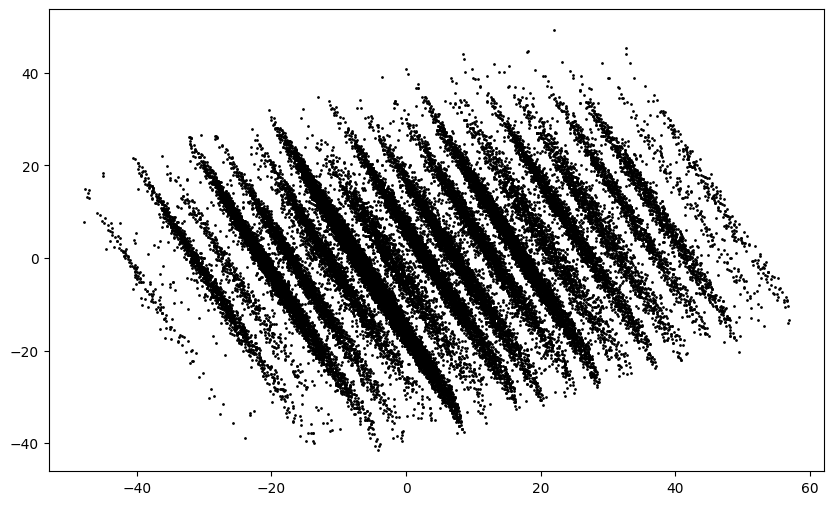

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(*x_proj.T, s=1, color='black')
plt.show()

In [27]:
estimators = [
    KMeans(n_clusters=2, n_init=10),
    KMeans(n_clusters=3, n_init=10),
    KMeans(n_clusters=4, n_init=10),
    KMeans(n_clusters=5, n_init=10)
]

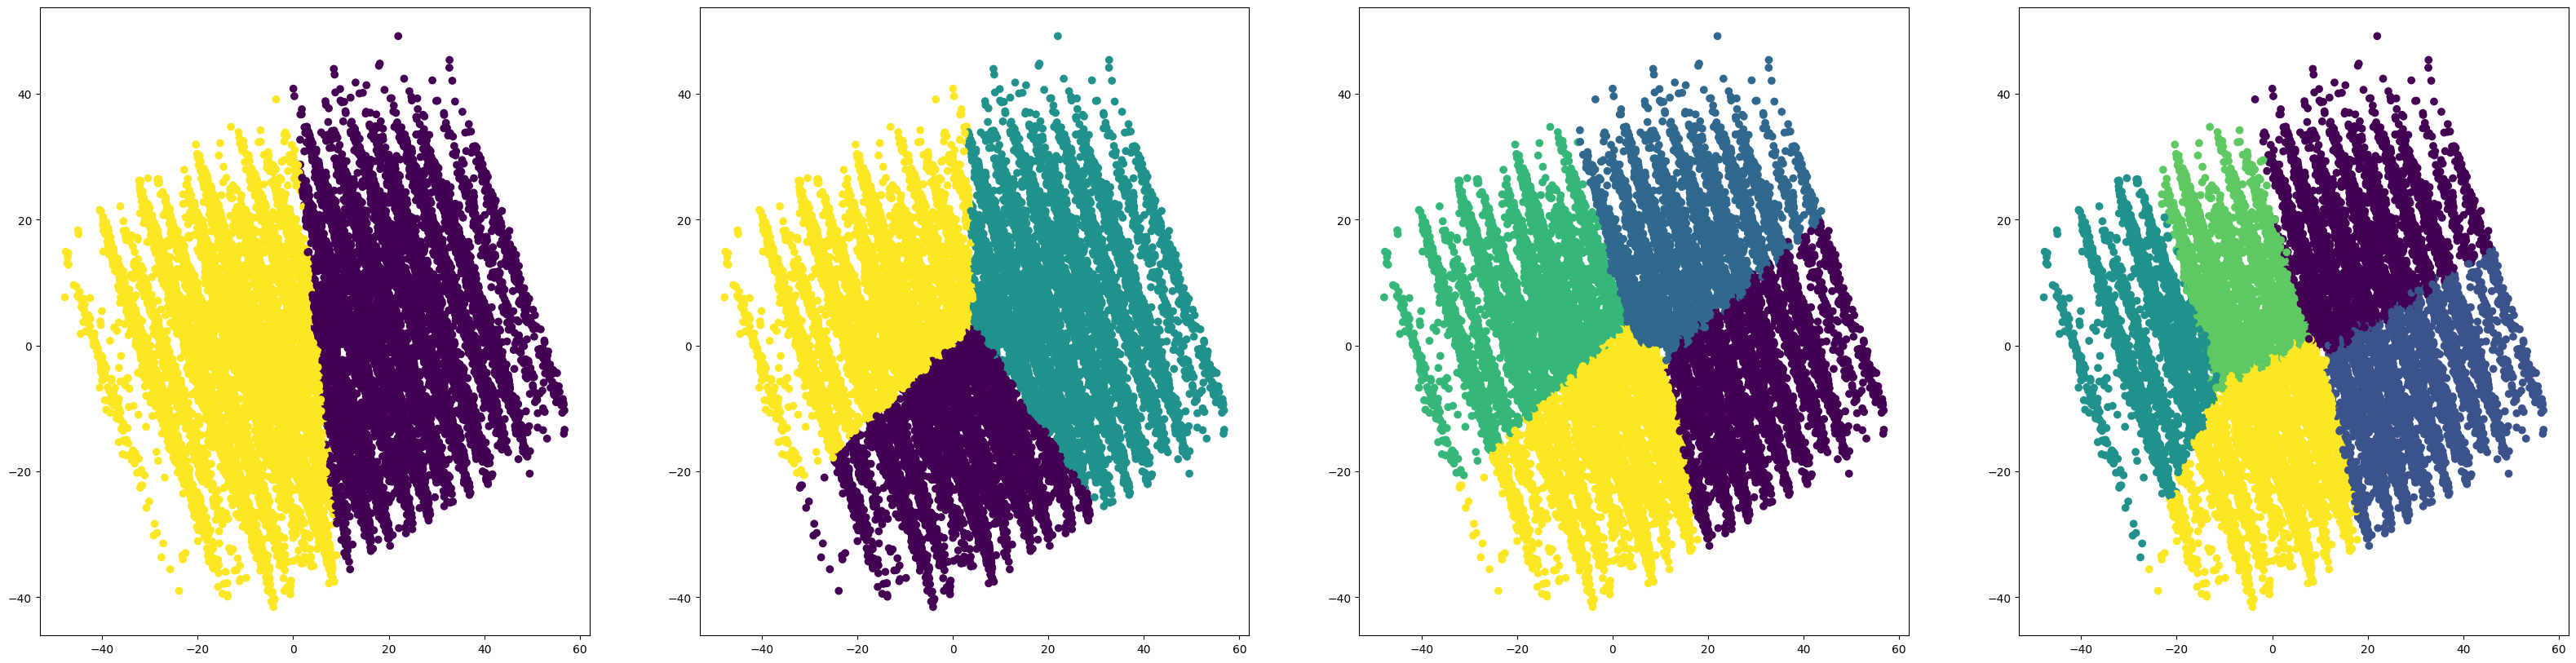

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))

for i, estimator in enumerate(estimators):
    estimator.fit(x)
    labels = estimator.labels_
    ax[i].scatter(*x_proj.T, c=labels)
    
plt.show()